# Imports and installations

In [ ]:
!pip install py-pde

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 272.0/272.0 KB 8.9 MB/s eta 0:00:00


In [ ]:
import pde
import numpy as np
from matplotlib import pyplot as plt

# Setup

In [ ]:
space_shape = np.array([300,100],dtype=np.float64)
bin_width = 10
P1_cost_centre = (0.1*space_shape[0],0.5*space_shape[1])
P2_cost_centre = (0.9*space_shape[0],0.5*space_shape[1])
Kc_functions = [f"10+2000*exp(-0.00005*((x-{P1_cost_centre[0]})**2+(y-{P1_cost_centre[1]})**2))",
                f"10+2000*exp(-0.00005*((x-{P2_cost_centre[0]})**2+(y-{P2_cost_centre[1]})**2))"]
Kb = [0.5,0.5]

In [ ]:
# Set up initial state
grid = pde.UnitGrid(space_shape)
state = pde.FieldCollection([
    pde.ScalarField(grid,data=10000), # number of plasmid 2 (p2)
    pde.ScalarField(grid,data=10000), # number of plasmid 2 (p2)
    pde.ScalarField.from_expression(grid,Kc_functions[0]), # plasmid 1 Kc values
    pde.ScalarField.from_expression(grid,Kc_functions[1]), # plasmid 2 Kc values
    pde.ScalarField(grid,data=1000) # initial number of cells at each point in space
])

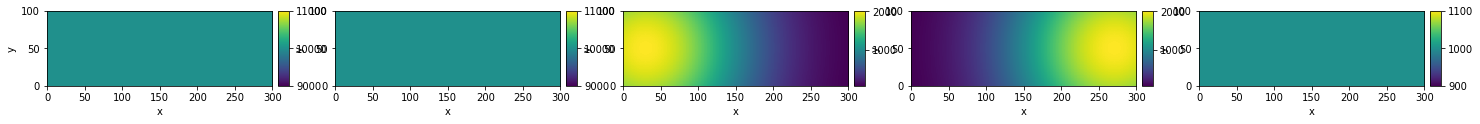

In [ ]:
# Plot initial state
state.plot()

In [ ]:
# Set up PDEs (dup ori)
dup_ori = True
ben_p1,ben_p2 = Kb
eq = pde.PDE(
    {'p1' : f'1*p1*(1 - (({"p1+p2" if dup_ori else "p1"})/({50 if dup_ori else 50/2}))) - (((((cost_p1**4/(p1**4 + cost_p1**4))+(cost_p2**4/(p2**4 + cost_p2**4)))) - (cost_p1**4/(p1**4 + cost_p1**4)))/(((cost_p1**4/(p1**4 + cost_p1**4))+(cost_p2**4/(p2**4 + cost_p2**4)))))*((cells**2/(cells**2 + 10000**2)) + 0.02*(p1/(p1 + 1000)) + 0.02*(p2/(p2 + 1000)))*(p1)',
     'p2' : f'1*p2*(1 - (({"p1+p2" if dup_ori else "p2"})/({50 if dup_ori else 50/2}))) - (((((cost_p1**4/(p1**4 + cost_p1**4))+(cost_p2**4/(p2**4 + cost_p2**4)))) - (cost_p2**4/(p2**4 + cost_p2**4)))/(((cost_p1**4/(p1**4 + cost_p1**4))+(cost_p2**4/(p2**4 + cost_p2**4)))))*((cells**2/(cells**2 + 10000**2)) + 0.02*(p1/(p1 + 1000)) + 0.02*(p2/(p2 + 1000)))*(p2)',
     'cost_p1' : 0,#"Heaviside(t-50,0)*40*exp((-0.5*(t-75)**2)/(10**2))",
     'cost_p2' : 0,#'Heaviside(t-50,0)*-40*exp((-0.5*(t-75)**2)/(10**2))',
     'cells' : f'10*laplace(cells) + cells*1*(1 - (cells/10000))*(cost_p1**4/(p1**4 + cost_p1**4))*(cost_p2**4/(p2**4 + cost_p2**4))*(p1**4/(p1**4 + {ben_p1}**4))*(p2**4/(p2**4 + {ben_p2}**4)) - (cells*(cells**2/(cells**2 + 10000**2)) + 0.02*(p1/(p1 + 1000)) + 0.02*(p2/(p2 + 1000)))'
                 })

# Simulation

In [ ]:
# Run simulation
storage = pde.MemoryStorage()
solution_dup = eq.solve(state,t_range=3000, tracker=storage.tracker(interval=25))

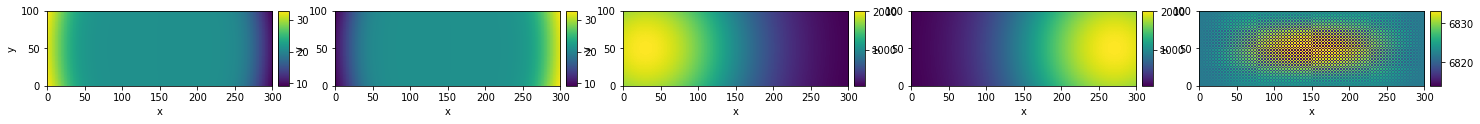

In [ ]:
storage[-1].plot()

I used this notebook to test variants of the Kc function to find one that did not cause the cell population to crash

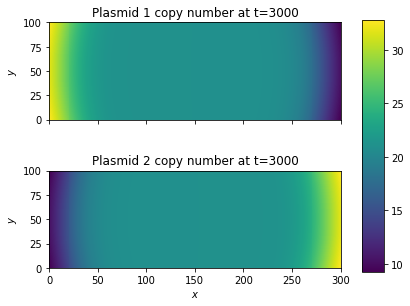

In [ ]:
# Plotting the Plasmid CN distributions
# Create the figure and axis objects
fig, ax = plt.subplots(nrows=2, figsize=(6, 5), sharex=True, sharey=False)

im1 = ax[0].pcolormesh(storage[-1][0].data.T)
ax[0].set_title("Plasmid 1 copy number at t=3000")
im2 = ax[1].pcolormesh(storage[-1][1].data.T)
ax[1].set_title("Plasmid 2 copy number at t=3000")

# Add colorbar and rearrange
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im2, cax=cbar_ax, orientation='vertical', shrink=0.6, pad=0.02)

# Set the labels for the x and y axes
ax[1].set_xlabel('$x$')
ax[1].set_ylabel('$y$')
ax[0].set_ylabel('$y$')

# set aspect ratio
ax[0].set_aspect('equal')
ax[1].set_aspect('equal')

#plt.savefig('CN plots.pdf')
plt.show()